# Example - uncertainty estimates with Monte Carlo

by D. Ilić, N. Rakić, May 2023 (last modified)

Open source code FANTASY (Fully Automated pythoN tool for AGN Spectra analYsis) is a python based code for simultaneous multi-component fitting of AGN spectra, optimized for the optical rest-frame band (3600-8000A). For the detailed description of the FANTASY code and its usage, please refere to the general <a href="https://fantasy-agn.readthedocs.io/en/latest/Tutorial.html">Tutorial</a>. Here we illustrate an example tutorial how to run FANTASY on a set of spectra, with one approach for spectral uncertainty estimates. 

FANTASY currently treats the uncertainties in the spectra, and consequently in measured spectral quantities, using a Monte Carlo approach, similar as in <a href="https://ui.adsabs.harvard.edu/abs/2020ApJS..249...17R/abstract">Rakshit et al. 2020</a>. 

We introduce a command *monte_carlo(nsample=N)*, which creates a number N of mock spectra (set by the user), by adding Gaussian random noise to the original spectrum at each pixel. The same fitting model is then applied to all mock spectra as was done for the original one. Note that before running the *monte_carlo* command, a spectrum must be fitted at least once.

Spectral quantities of interest (flux, line widths and shifts) can be estimated from the original and mock spectra, giving the distribution of each spectral quantity. For the uncertainty one can then take the semi-amplitude of the range enclosing the 16th and 84th percentiles of the distribution (see also Ilic et al. 2023).

Below is the described example. Once again, for description of general steps of the FANTASY code usage, please refere to the basic <a href="https://fantasy-agn.readthedocs.io/en/latest/Tutorial.html">Tutorial</a>.

In [1]:
#Before starting, we call some of the standard python packages, such as matplotlib, pandas, numpy, etc. 

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

from natsort import natsorted

import numpy as np
import pandas as pd

import glob

import json
from multiprocessing import Pool, cpu_count
plt.style.use('seaborn-talk')

<font size=4> 1. Importing commands </font>

In [2]:
# Below command import the necessary commands for preprocessing and fitting of spectra 

from fantasy_agn.tools import read_sdss, read_text, read_gama_fits

from fantasy_agn.models import create_input_folder, automatic_path

from fantasy_agn.models import create_feii_model, create_model, create_tied_model, continuum, create_line, create_fixed_model

<font size="4"> 2. Making a list of spectra to be fitted </font> 

In [3]:
# This command makes a list of all spectra with the name starting with "spec" and extension ".fits", 
# from the folder of this notebook or a folder with the given path e.g.,'/path/to/files/spec*.txt'

files= glob.glob('spec*.fits')

In [4]:
# In this example, the folder contains two spectra, listed below.

print(files)

['spec-1059-52618-0453.fits', 'spec-0461-51910-0361.fits', 'spec-2770-54510-0433.fits']


In [5]:
# This command checks for the number of available CPUs of the computer facility in use

print(cpu_count())

16


<font size="4"> 3. Defining a function for spectral preparation and fitting </font> 

In [86]:
# Following the general steps of the FANTASY code usage, given in the basic Tutorial 
# (https://fantasy-agn.readthedocs.io/en/latest/Tutorial.html), we define the function which: 
# 1) reads an AGN spectrum and corrects for Galactic extinction,redshift, and the host galaxy contribution;
# 2) creates automatic path of the input line lists;
# 3) defines fitting model and fits the original spectrum; 
# 4) creates output files: '*_model.csv' for the fitted components and '*_pars.json' for the parameters; 
# 5) creates N mock spectra, run the same model for the fittings, and saves in default file '*_pars.csv'.

# NOTE: Writing data from the fits files is optimized for the SDSS header, be aware that
#       other fits file may contain other data/keywords.

# NOTE: 
# In general you could create as little as 50 mock spectra to get the uncertainties (see Rakshit et al. 2020). 
# Here we generated 500 mock spectra so we could plot nice corner plot (see below).



def fitting(unit):
	try:

#  reads an AGN spectrum, corrects for Galactic extinction, redshift, and host galaxy
		s=read_sdss(unit)
		s.err=np.abs(s.err) #make sure that all errors are positive        
		s.DeRedden()
		s.CorRed()
		s.fit_host_sdss()
		plt.title(s.name.split('/')[-1].split('.')[0])
		plt.savefig(s.name+'_host.pdf')

# crops a spectrum, and creates automatic path of the input line lists      
		s.crop(4000,7000)
		automatic_path(s)

# defines fitting model
		cont=continuum(s,min_refer=5350, refer=5550, max_refer=5650,min_index1=-3.7, max_index1=1,max_index2=3)
		broad=create_model(['hydrogen.csv', 'helium.csv'], prefix='br', fwhm=2000,min_fwhm=1000)
		narrow=create_tied_model(name='OIII5007',files=['narrow_basic.csv','hydrogen.csv', 'helium.csv'],prefix='nr',min_amplitude=0, fwhm=300,min_offset=-300, max_offset=300, min_fwhm=10, max_fwhm=1000)
		outOIII5007=create_line(name="outOIII5007",pos=5006.803341,fwhm=1000,ampl=10,min_fwhm=1000,max_fwhm=1800,offset=0,min_offset=-3000,max_offset=0)
		outOIII4958 = create_line("outOIII4958",pos=4958.896072,fwhm=outOIII5007.fwhm,ampl=outOIII5007.ampl / 3.0, offset=outOIII5007.offs_kms)
		fe=create_feii_model(max_fwhm=6000)
		out=outOIII5007+outOIII4958
		model =cont+narrow+broad+fe+out

# fits a spectrum with the above model, iterate 2 times        
		s.fit(model, ntrial=2)  
		print("fit ok")
        
# creates a file to save the fitting results of the original spectra  
		d={'wave':s.wave,'flux':s.flux,'error':s.err,'model':model(s.wave),'cont':cont(s.wave), 'narrow':narrow(s.wave), 'broad':broad(s.wave), 'fe':fe(s.wave),'out':out(s.wave)}
		df=pd.DataFrame(d)
		df.to_csv(s.name+'_model.csv')
		dicte=zip(s.gres.parnames, s.gres.parvals)
		res=dict(dicte)
		res['redshift']= float(s.z)
		res['RA']=float(s.ra)
		res['dec']=float(s.dec)
		res['fiber']=str(s.fiber)
		res['mjd']=float(s.mjd) 
		res['plate']=str(s.plate)

# creates a file to save the fitting results of the original spectra  
		with open(s.name+'_pars.json', 'w') as fp:
				json.dump(res, fp)

# creates N=500 mock spectra, fits the same model, and write the fitting results.                
		s.monte_carlo(nsample=500)
		print("mcmc ok")
    
	except :
		pass


<font size="4"> 4. Running the above function on all listed spectra </font> 

In [35]:
if __name__ == "__main__":
	
	
	pool = Pool()#processes=(cpu_count() - 1))  # Create a multiprocessing Pool
	pool.map(fitting, files)


Host contribution is negliglable
Host contribution is negliglable
Directory  spec-0461-51910-0361  already exists
global spec-0461-51910-0361/
Directory  Directory spec-1059-52618-0453  spec-2770-54510-0433 already exists 
 already existsglobal
 globalspec-1059-52618-0453/ 
spec-2770-54510-0433/
stati 118829.84895381817
stati 303200.3258724115
1 iter stat:  198.2415891863002
1 iter stat:  11.967124601660089
stati 103195.07643200555
2 iter stat:  78.09676958380987
fit ok
2 iter stat:  3.830125467366088
fit ok
1 iter stat:  9.490706956271879
2 iter stat:  6.692557719217348
fit ok
mcmc ok
mcmc ok
mcmc ok


<font size="4.5"> You are DONE!  </font>



<font size="4"> 5. Plotting the results </font> 

You can plot the fitting results from the *model.csv saved data, using your favorite plotting style, an example is given below.

spec-0461-51910-0361_model.csv


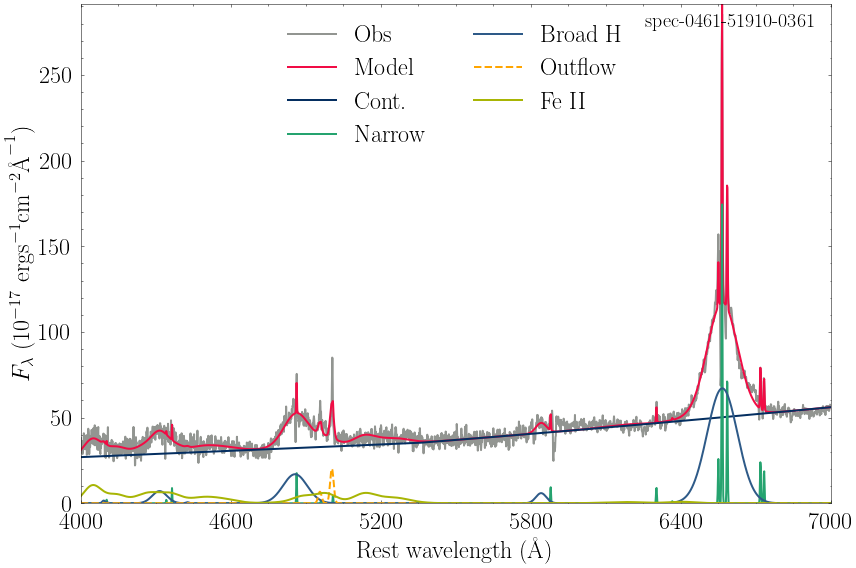

spec-1059-52618-0453_model.csv


<Figure size 252x189 with 0 Axes>

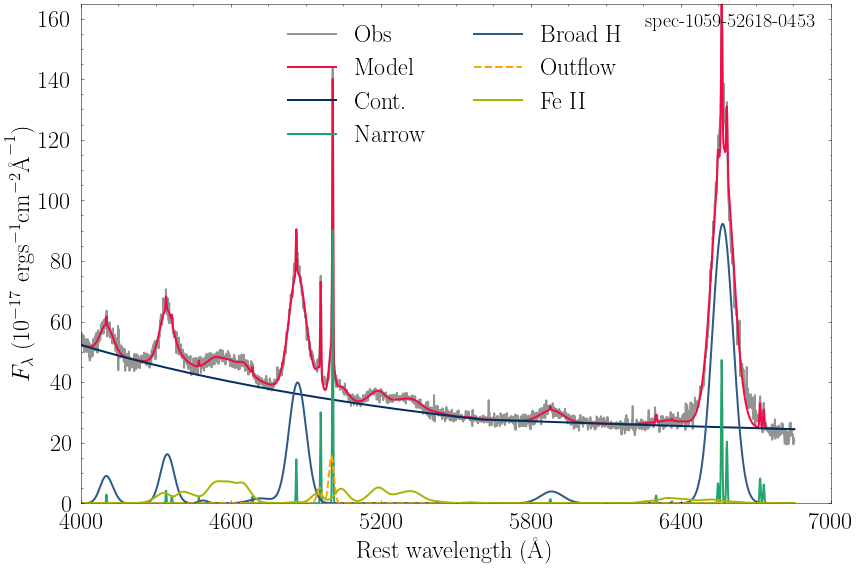

spec-2770-54510-0433_model.csv


<Figure size 252x189 with 0 Axes>

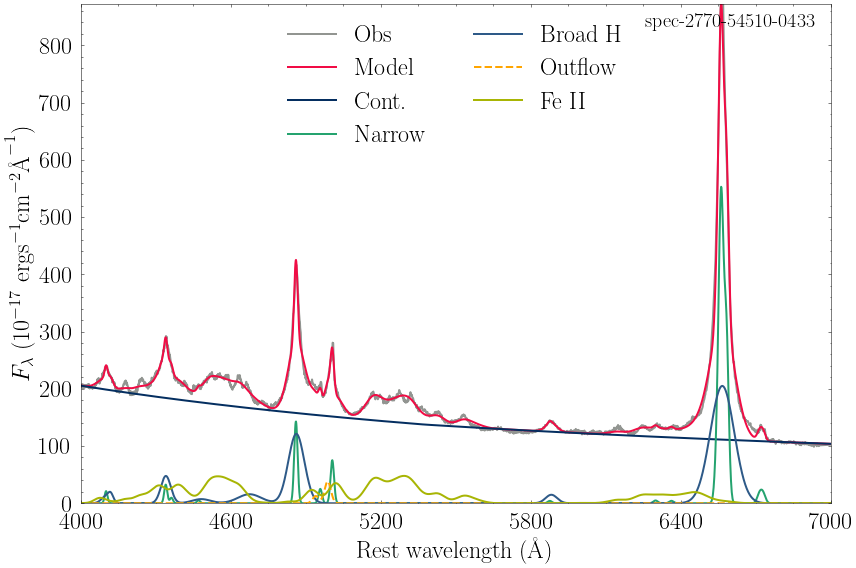

<Figure size 252x189 with 0 Axes>

In [36]:
i=0
x_tics=np.linspace(4000,7000, 6)

for file in natsorted(glob.glob('*model.csv')):
    print(file)
  
    df=pd.read_csv(file)
    
    plt.style.use(['nature', 'science'])

    fig, ax =plt.subplots(figsize=(12,8))
    
    plt.plot(df.wave, df.flux, '-', color="#929591", label='Obs', lw=2)
    plt.plot(df.wave, df.model, '-', color="#F10C45", label='Model', lw=2)
    
    plt.plot(df.wave, df.cont, '-', color="#042E60", label='Cont.', lw=2)
    plt.plot(df.wave, df.narrow, '-', color='#25A36F', label='Narrow',lw=2)
    plt.plot(df.wave, df.broad, '-', color="#2E5A88",label='Broad H', lw=2)
    plt.plot(df.wave, df.out, '--', color="orange",label='Outflow', lw=2)
    plt.plot(df.wave, df.fe, '-', color='#A8B504', label='Fe II', lw=2) ##CB416B
    
    try:
      plt.plot(df.wave, df.fe_forb, '-', color='xkcd:black', label='[Fe II]', lw=4)
    except:
      pass

    plt.xticks(x_tics, fontsize=24)
    plt.yticks(fontsize=24)
    plt.tick_params(which='both', direction="in")
    
    plt.ylim(0,df.model.max())
    plt.xlim(4000,7000)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    plt.legend(loc='upper center',  prop={'size': 24}, frameon=False, ncol=2)
    plt.xlabel(r'Rest wavelength ($\rm{\AA}$)', fontsize=24)
    plt.ylabel(r'$F_{\lambda}$ ($10^{-17}$ $\rm{erg s}^{-1}\rm{cm}^{-2}\rm{\AA}^{-1}$)', fontsize=24)
    
    name=file.split('.')[0]+'.pdf'

    plt.text(0.98, 0.98,name[:20],fontsize=20,ha='right', va='top',transform=ax.transAxes)

    plt.tight_layout()
    plt.savefig(name, dpi=300,bbox_inches='tight')
    i+=1
    plt.show()
    plt.close()
    plt.clf()



<font size="4"> 6. Inspecting the fitting results </font> 

The fitting parameters and the distribution of erros, are given in the files '*_pars.json' and   '*_pars.csv' files, respectfully. 

In [83]:
# The file e.g.'spec-1059-52618-0453_pars.csv' displayes the distributions of fitting parameters,
# obtained from fitting the 50 mock spectra with the same model.

# Read the data from a CSV file
data = pd.read_csv('spec-1059-52618-0453_pars.csv')
data


,Unnamed: 0,brokenpowerlaw.refer,brokenpowerlaw.ampl,brokenpowerlaw.index1,brokenpowerlaw.index2,nr_OIII5007.ampl,nr_OIII5007.offs_kms,nr_OIII5007.fwhm,nr_NII6584.ampl,nr_[OIII]_4363.ampl,...,feii.amp_z4F,feii.amp_y4G,feii.amp_b4G,feii.amp_x4D,feii.amp_y4P,feii.offs_kms,feii.fwhm,outOIII5007.ampl,outOIII5007.offs_kms,outOIII5007.fwhm
0,0,5601.833278,27.661115,-1.886605,1.285373,90.030909,79.927144,262.552354,21.709037,2.463396,...,3.766073,1.222758,0.059910,1.784739,1.767865,1297.964381,3447.866124,16.189181,-215.436777,1375.076704
1,1,5602.949862,27.603594,-1.897492,1.310958,93.229528,79.828271,250.631663,19.212871,4.685545,...,4.864951,1.095603,0.166194,1.875734,1.781046,1244.039688,3353.439627,16.394772,-225.711097,1389.038436
2,2,5602.955127,27.602271,-1.895995,1.288885,91.482020,79.675358,258.780422,18.876666,3.934760,...,5.735411,0.975745,0.038551,1.698598,1.988186,1349.881506,3381.244256,17.065463,-227.202391,1301.666745
3,3,5599.814785,27.596388,-1.885510,1.259516,90.810037,80.495484,256.763539,20.432095,0.060480,...,4.335902,0.761467,0.367688,1.930351,1.663426,1260.497119,3401.508435,15.359279,-230.380607,1428.906926
4,4,5604.364059,27.604931,-1.894737,1.250180,90.277398,78.652679,263.892457,19.019876,2.637820,...,7.611617,0.601650,0.292939,1.926874,2.025564,1247.948653,3333.656222,15.567539,-229.093132,1477.972070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,5593.732880,27.654418,-1.907969,1.304835,88.984667,80.165934,244.015207,22.370792,1.726612,...,2.369640,0.033113,0.241139,1.433509,0.008827,786.272857,5234.744936,17.996355,-158.775120,1000.057904
496,496,5590.103641,27.657548,-1.902963,1.310495,88.164603,85.736888,248.875368,21.010313,3.674431,...,4.977409,0.074588,0.078061,1.488694,0.000000,742.629534,5245.025753,17.807423,-148.302027,1000.000000
497,497,5588.797113,27.623553,-1.901716,1.289579,86.935027,81.753303,245.770348,19.911446,3.758005,...,4.493472,0.064236,0.198553,1.586191,0.000000,727.870952,5217.491484,17.228992,-133.059601,1000.000000
498,498,5587.945574,27.607072,-1.901192,1.318754,88.294354,79.623165,251.342968,24.922500,0.163727,...,4.429281,0.084288,0.174495,1.615609,0.000000,795.732192,5055.713984,17.541603,-171.294738,1000.000000


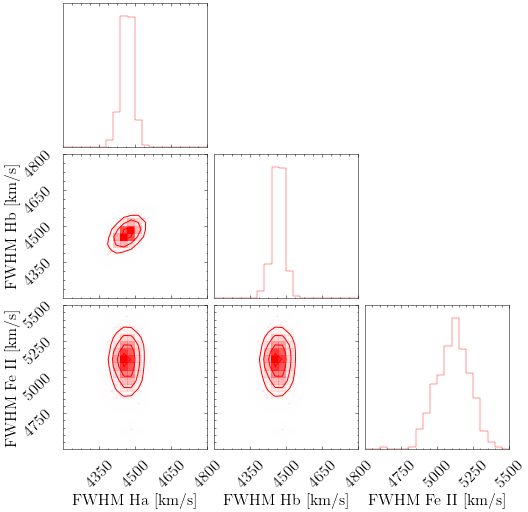

In [85]:
# For the distribution of uncertainties, you can make a well-known corner plot.
# Here we used corner package (https://corner.readthedocs.io/en/latest/install/) 

# IMPORTANT NOTE: 
# In general you could create as little as 50 mock spectra to get the uncertainties (see Rakshit et al. 2020). 
# Here we generated 500 mock spectra so we could plot contours within corner plot.

import corner

# Define the format of the panels
CORNER_KWARGS = dict(
    smooth=0.95,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    max_n_ticks=4,
    color="red",
    size=6,
    tick_param=dict(axis='both', labelsize=16),
  
)

# Select the columns you want to include in the corner plot
columns = ['br_Ha_6563.fwhm', 'br_Ha_6563.fwhm', 'feii.fwhm']

# Extract the selected columns from the data and define labels
selected_data = data[columns]
labels = ['FWHM Ha [km/s]', 'FWHM Hb [km/s]', 'FWHM Fe II [km/s]']

# Create the corner plot with axis labels, and range of values
corner_plot = corner.corner(selected_data, labels=labels, range=[(4200, 4800), (4200, 4800), (4500, 5500)],**CORNER_KWARGS)

for ax in corner_plot.get_axes():
    ax.tick_params(axis='both', labelsize=16)


# Display the plot
corner_plot.show()


**References**

1. [Rakic, N., 2022, MNRAS, 516, 1624](https://ui.adsabs.harvard.edu/abs/2022MNRAS.516.1624R/abstract)
2. [Ilic, D. et al. 2020, A&A, 638, 13](https://ui.adsabs.harvard.edu/abs/2020A%26A...638A..13I/abstract)
3. [Kovacevic, J. et al. 2010, ApJS, 189, 15](https://ui.adsabs.harvard.edu/abs/2010ApJS..189...15K/abstract)
4. [Shapovalova, A. I. et al. 2012, ApJS, 202, 10](https://ui.adsabs.harvard.edu/abs/2012ApJS..202...10S/abstract)
5. Ilic, D., Rakic, N., Popovic, L. C., 2023, ApJS, accepted

### END ###